#### Загрузка набора данных

In [1]:
import pandas

test_data = pandas.read_csv('data/test.csv')
training_data = pandas.read_csv('data/training.csv')
validation_data = pandas.read_csv('data/validation.csv')

print(test_data.info())
print(training_data.info())
print(validation_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


#### Подготовка набора данных

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def prepare_text(text):
    text = text.lower()

    stop_words = set(stopwords.words('english'))
    
    # Удаление небуквенных символов и приведение к нижнему регистру
    text = ''.join(character for character in text if character.isalpha() or character.isspace())

    # Лемматизация
    tokens = [lemmatizer.lemmatize(word) for word in text.split()]

    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    text = ' '.join(tokens)
    
    return text

test_data['text'] = test_data['text'].apply(prepare_text)
training_data['text'] = training_data['text'].apply(prepare_text)
validation_data['text'] = validation_data['text'].apply(prepare_text)

print(test_data)
print(training_data)
print(validation_data)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                   text  label
0           im feeling rather rotten im ambitious right      0
1                          im updating blog feel shitty      0
2       never make separate ever want feel like ashamed      0
3     left bouquet red yellow tulip arm feeling slig...      1
4                            wa feeling little vain one      0
...                                                 ...    ...
1995  keep feeling like someone unkind wrong think g...      3
1996  im feeling little cranky negative doctor appoi...      3
1997  feel useful people give great feeling achievement      1
1998  im feeling comfortable derby feel though start...      1
1999  feel weird meet w people text like dont talk f...      4

[2000 rows x 2 columns]
                                                    text  label
0                                  didnt feel humiliated      0
1      go feeling hopeless damned hopeful around some...      0
2              im grabbing 

#### Построение частотного словаря

In [3]:
import collections

test_data_words = []

for _, row in test_data.iterrows():
    test_data_words.extend(row['text'].split())

test_data_dictionary = dict(collections.Counter(test_data_words))

test_data_dictionary = dict(sorted(test_data_dictionary.items(), key=lambda item: item[1], reverse=True))

print(list(test_data_dictionary.items())[:10])

[('feel', 1441), ('feeling', 688), ('like', 374), ('im', 310), ('wa', 297), ('really', 118), ('time', 116), ('know', 105), ('get', 103), ('people', 99)]


#### Распределение меток по классам

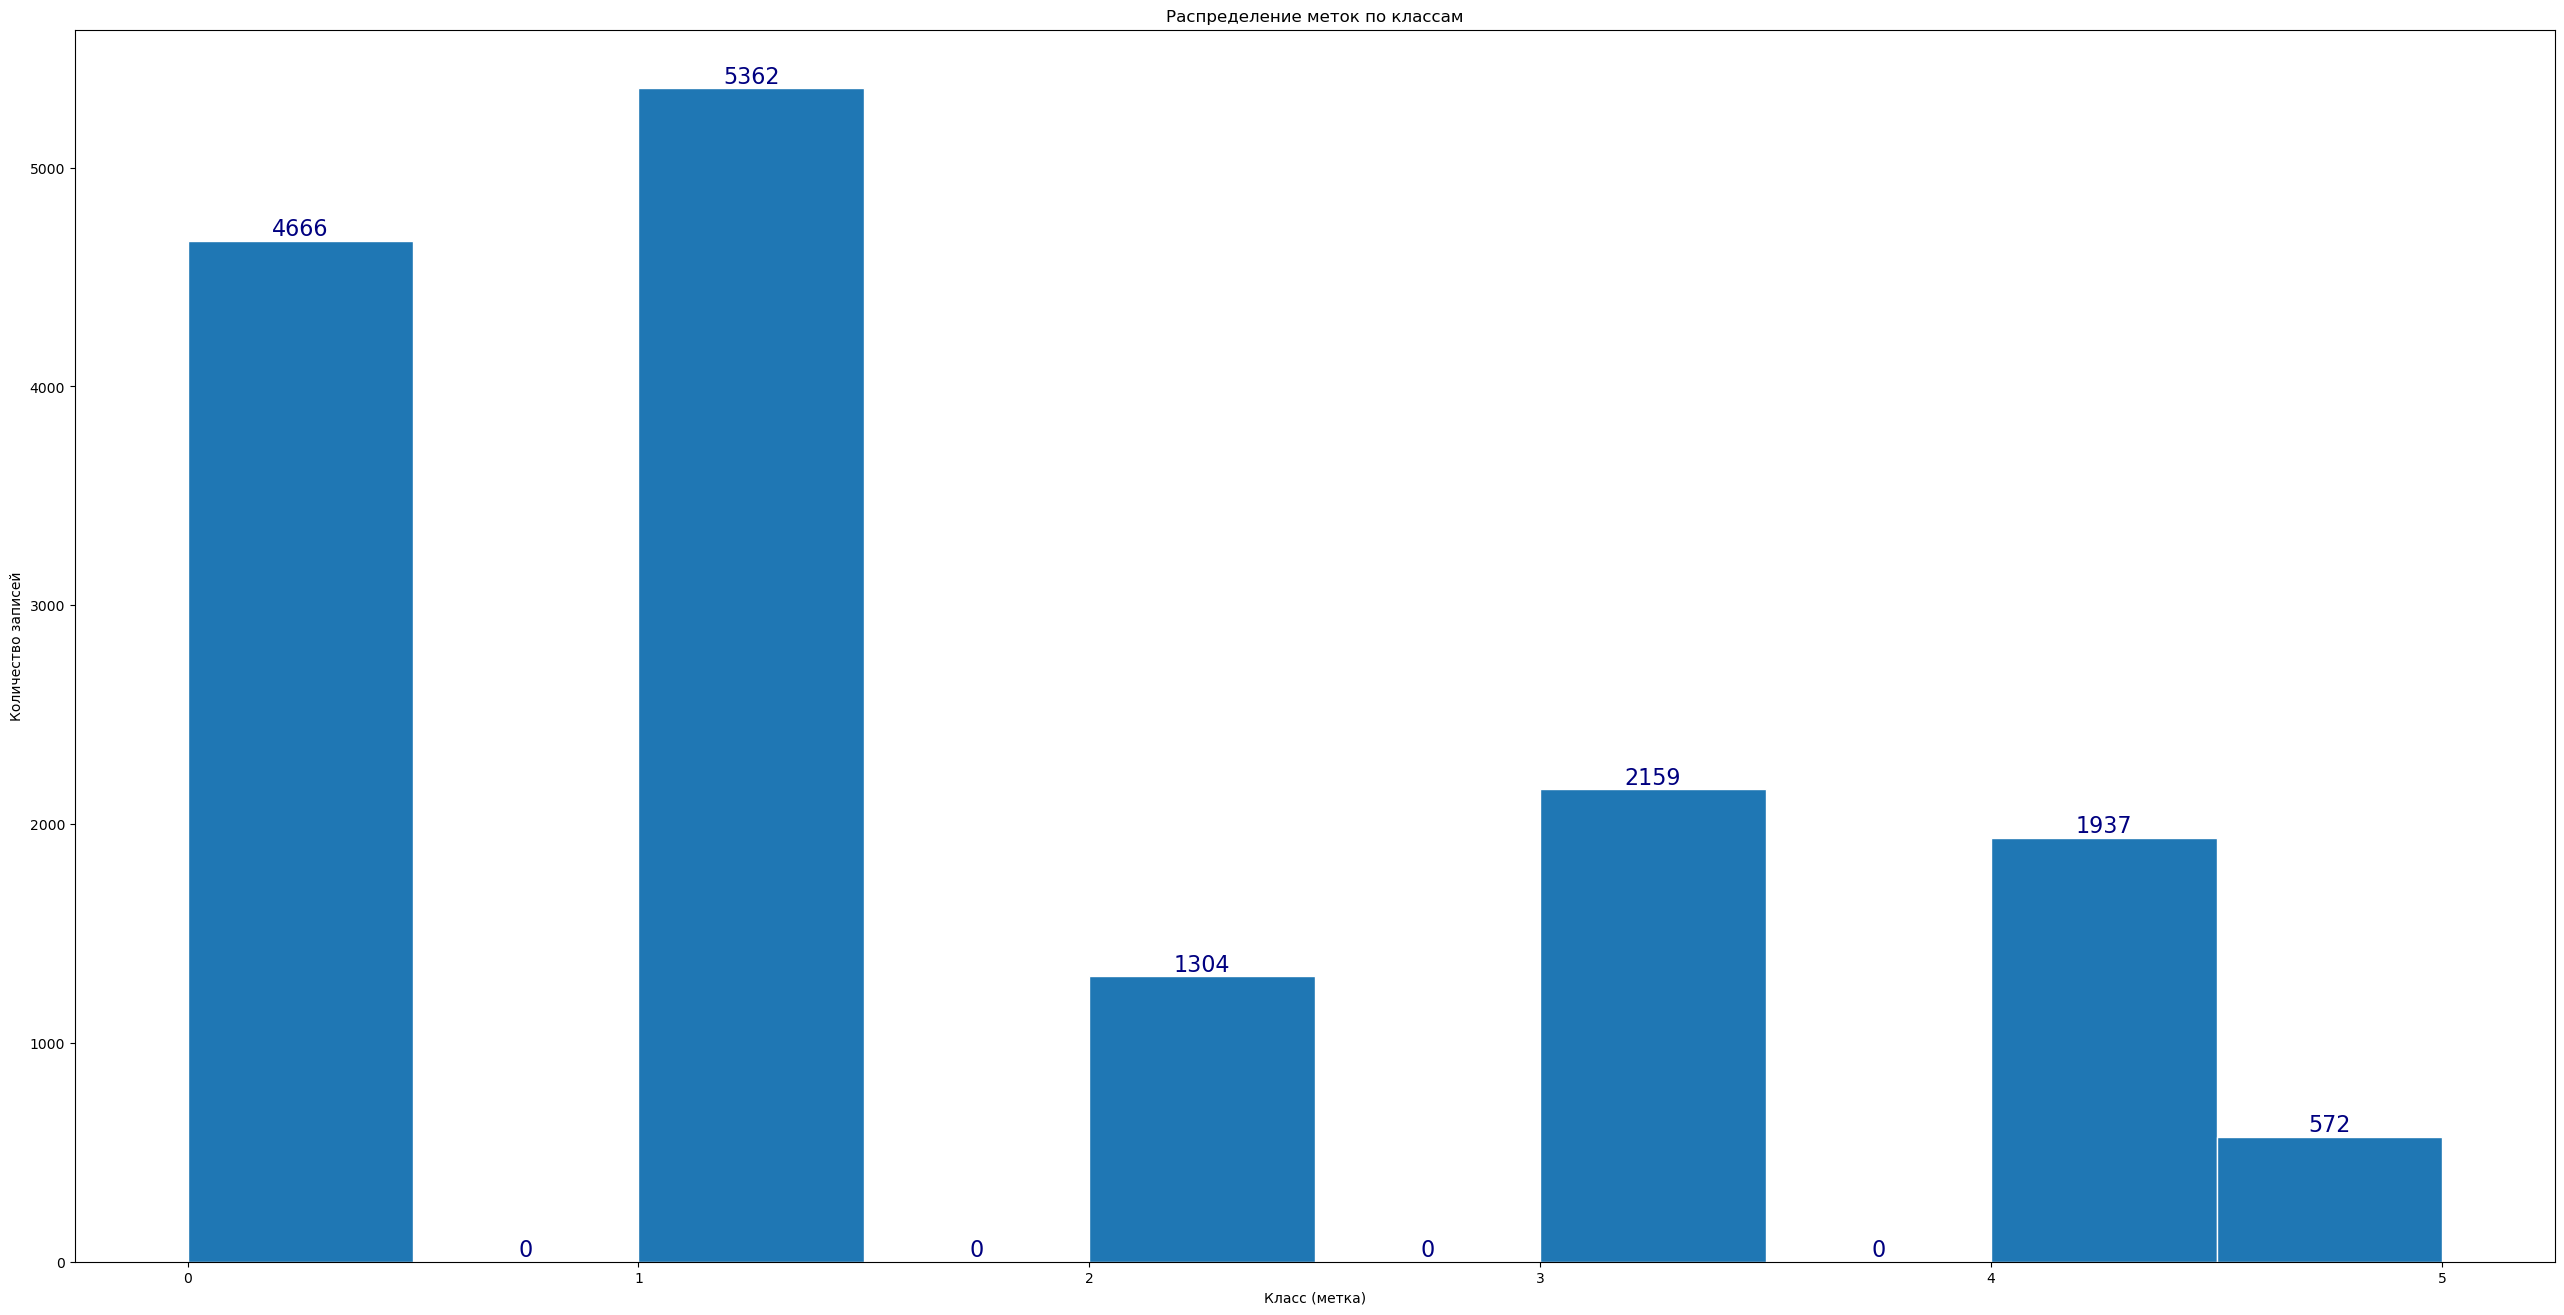

In [4]:
from matplotlib import pyplot as plot

plot.figure(figsize=(32, 16))

values, bins, bars = plot.hist(training_data['label'], edgecolor='white')

plot.xlabel("Класс (метка)")
plot.ylabel("Количество записей")

plot.title('Распределение меток по классам')

plot.bar_label(bars, fontsize=16, color='navy')

plot.show()

#### Подбор оптимальных параметров и тренировка модели

In [135]:
import numpy
import pandas

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

documents = training_data['text']

vectorizer = TfidfVectorizer(max_features=4096)

tfidf_matrix = vectorizer.fit_transform(documents)

X_validation = vectorizer.transform(validation_data['text'])

vectors = tfidf_matrix.toarray()

N = vectors.shape[0]
L = vectors.shape[1]
C = 1

X_training = vectors.reshape(N, L, C)

y = numpy.array(training_data['label'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

model = Sequential()

model.add(Conv1D(filters=12, kernel_size=4, activation='relu', input_shape=(L, C)))
model.add(Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(L, C)))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(L, C)))

model.add(MaxPooling1D(pool_size=4))

model.add(Flatten())

model.add(Dense(6, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.01)))

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_training, y, epochs=40, validation_data=(X_validation, numpy.array(validation_data['label'])))

C:\Users\Aleksei\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - accuracy: 0.3177 - loss: 1.6936 - val_accuracy: 0.3520 - val_loss: 1.5923
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.3314 - loss: 1.5885 - val_accuracy: 0.3520 - val_loss: 1.5812
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.3307 - loss: 1.5834 - val_accuracy: 0.3520 - val_loss: 1.5771
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.3599 - loss: 1.5712 - val_accuracy: 0.5095 - val_loss: 1.4375
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.5247 - loss: 1.3424 - val_accuracy: 0.6230 - val_loss: 1.0733
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6695 - loss: 0.9553 - val_accuracy: 0.7245 - val_loss: 0.7964
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.7521 - loss: 0.7130 - val_accuracy: 0.7460 - val_loss: 0.7046
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.7922 - loss: 0.5945 - 

#### Графики тренировки модели

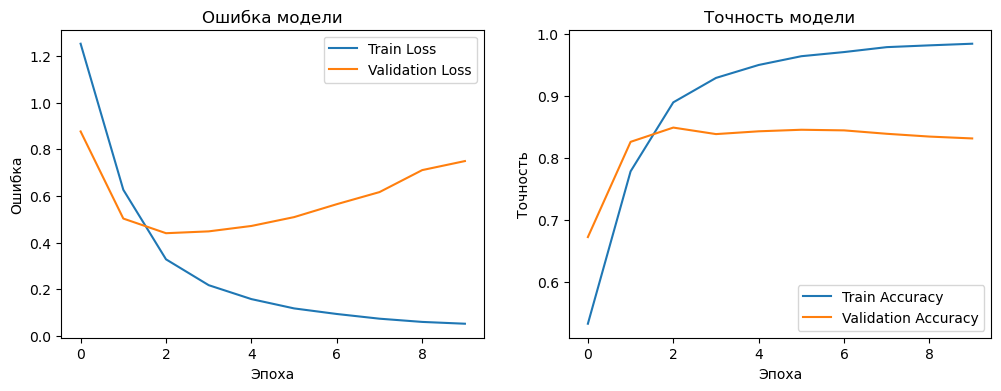

In [119]:
import matplotlib.pyplot as plot

plot.figure(figsize=(12, 4))

plot.subplot(1, 2, 1)

plot.plot(history.history['loss'], label='Train Loss')
plot.plot(history.history['val_loss'], label='Validation Loss')

plot.title('Ошибка модели')

plot.ylabel('Ошибка')
plot.xlabel('Эпоха')

plot.legend()

plot.subplot(1, 2, 2)

plot.plot(history.history['accuracy'], label='Train Accuracy')
plot.plot(history.history['val_accuracy'], label='Validation Accuracy')

plot.title('Точность модели')

plot.ylabel('Точность')
plot.xlabel('Эпоха')

plot.legend()

plot.show()

#### Проверка модели на тестовых данных

In [121]:
import numpy

vectors = vectorizer.fit_transform(test_data['text']).toarray()

N = vectors.shape[0]
L = vectors.shape[1]
C = 1

X = vectors.reshape(N, L, C)

y = numpy.array(test_data['label'])

model.summary()

loss, accuracy = model.evaluate(X_test, y)

print(f'Потери: {loss}, Точность: {accuracy}')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 4093, 12)            │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 4092, 6)             │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 2046, 6)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 12276)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │          73,662 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,744 (866.19 KB)

 Trainable params: 73,914 (288.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,830 (577.46 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8282 - loss: 0.8330
Потери: 0.8166753649711609, Точность: 0.8230000138282776


#### Матрица ошибок

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


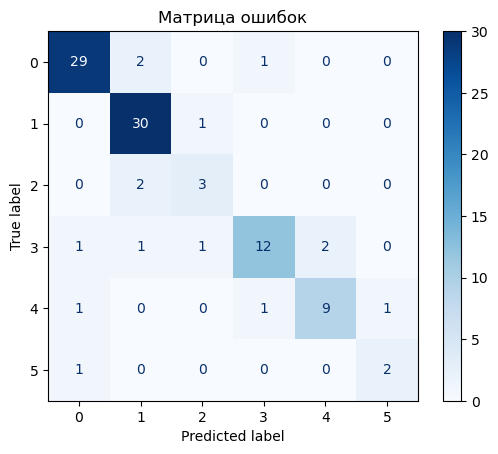

In [123]:
import matplotlib.pyplot as plot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_actual = test_data['label'][:100]
y_predicted = [list(l).index(max(list(l))) for l in model.predict(X_test[:100])]

matrix = confusion_matrix(y_actual, y_predicted)

display = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot(cmap=plot.cm.Blues)

plot.title('Матрица ошибок')

plot.show()